In [ ]:
#!wget https://zenodo.org/record/4281122/files/AI_Ready_DMSP_Data.csv

## Importing Importing Libraries

In [7]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob

from random import *

import time

from pickle import dump
import joblib

# from keras import backend as K
from tensorflow import keras as k
from tensorflow.keras import utils, models, layers, optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.layers import Dense, GRU, BatchNormalization, Activation, LSTM, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential

## Importing the dataset

In [8]:
# Reading the csv file
df = pd.read_csv('AI_Ready_DMSP_Data.csv')

In [9]:
# printing first few rows of the dataset
df.head()

,Datetimes,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX,ELE_TOTAL_ENERGY_FLUX_STD,ELE_AVG_ENERGY,ELE_AVG_ENERGY_STD,ID_SC,sin_ut,cos_ut,...,AE_5min,AL_5min,AU_5min,SymH_5min,PC_5min,vsw_5min,vx_5min,psw_5min,borovsky_5min,newell_5min
0,1987-01-12 12:57:00,51.143220,5.664024,2.057827e+08,0.411230,39.89341,0.411485,6.0,-0.246153,-0.969231,...,86.0,-61.0,25.0,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963
1,1987-01-12 12:58:00,54.137207,5.535848,2.509837e+08,0.478268,40.82392,0.478568,6.0,-0.250380,-0.968148,...,86.0,-61.0,25.0,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963
2,1987-01-12 13:01:00,62.928176,5.031172,4.469146e+08,0.603362,143.77360,0.604023,6.0,-0.263031,-0.964787,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
3,1987-01-12 13:02:00,65.719631,4.794780,1.934849e+10,0.103648,820.36560,0.103671,6.0,-0.267238,-0.963630,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
4,1987-01-12 13:03:00,68.392364,4.507448,3.913337e+11,0.114959,5291.57100,0.114959,6.0,-0.271440,-0.962455,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015


In [10]:
df.shape

(1945887, 154)

In [11]:
# creating the copy of the dataset
df_cumulative = df.copy()

In [12]:
# changing the date column into datetime format
df_cumulative = df_cumulative.set_index('Datetimes')
df_cumulative.index = pd.to_datetime(df_cumulative.index)

In [13]:
# list the columns 
df_cumulative.columns.to_list()

['SC_AACGM_LAT',
 'SC_AACGM_LTIME',
 'ELE_TOTAL_ENERGY_FLUX',
 'ELE_TOTAL_ENERGY_FLUX_STD',
 'ELE_AVG_ENERGY',
 'ELE_AVG_ENERGY_STD',
 'ID_SC',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'F107',
 'Bz',
 'By',
 'Bx',
 'AE',
 'AL',
 'AU',
 'SymH',
 'PC',
 'vsw',
 'vx',
 'psw',
 'borovsky',
 'newell',
 'F107_6hr',
 'Bz_6hr',
 'By_6hr',
 'Bx_6hr',
 'AE_6hr',
 'AL_6hr',
 'AU_6hr',
 'SymH_6hr',
 'PC_6hr',
 'vsw_6hr',
 'vx_6hr',
 'psw_6hr',
 'borovsky_6hr',
 'newell_6hr',
 'F107_5hr',
 'Bz_5hr',
 'By_5hr',
 'Bx_5hr',
 'AE_5hr',
 'AL_5hr',
 'AU_5hr',
 'SymH_5hr',
 'PC_5hr',
 'vsw_5hr',
 'vx_5hr',
 'psw_5hr',
 'borovsky_5hr',
 'newell_5hr',
 'F107_3hr',
 'Bz_3hr',
 'By_3hr',
 'Bx_3hr',
 'AE_3hr',
 'AL_3hr',
 'AU_3hr',
 'SymH_3hr',
 'PC_3hr',
 'vsw_3hr',
 'vx_3hr',
 'psw_3hr',
 'borovsky_3hr',
 'newell_3hr',
 'F107_1hr',
 'Bz_1hr',
 'By_1hr',
 'Bx_1hr',
 'AE_1hr',
 'AL_1hr',
 'AU_1hr',
 'SymH_1hr',
 'PC_1hr',
 'vsw_1hr',
 'vx_1hr',
 'psw_1hr',
 '

In [14]:
# Choose columns to drop
cols_to_drop = [c for c in df_cumulative.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('_5min'in c) | ('15min' in c)| ('5hr' in c) | ('F107_' in c) | ('vx' in c) | ('AE' in c) | ('newell' in c) | ('borovsky' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
df_cumulative = df_cumulative.drop(columns=cols_to_drop)

In [15]:
# List the new set of columns
df_cumulative.columns.to_list()

['SC_AACGM_LAT',
 'ELE_TOTAL_ENERGY_FLUX',
 'ID_SC',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'F107',
 'Bz',
 'By',
 'Bx',
 'AL',
 'AU',
 'SymH',
 'PC',
 'vsw',
 'psw',
 'Bz_6hr',
 'By_6hr',
 'Bx_6hr',
 'AL_6hr',
 'AU_6hr',
 'SymH_6hr',
 'PC_6hr',
 'vsw_6hr',
 'psw_6hr',
 'Bz_3hr',
 'By_3hr',
 'Bx_3hr',
 'AL_3hr',
 'AU_3hr',
 'SymH_3hr',
 'PC_3hr',
 'vsw_3hr',
 'psw_3hr',
 'Bz_1hr',
 'By_1hr',
 'Bx_1hr',
 'AL_1hr',
 'AU_1hr',
 'SymH_1hr',
 'PC_1hr',
 'vsw_1hr',
 'psw_1hr',
 'Bz_45min',
 'By_45min',
 'Bx_45min',
 'AL_45min',
 'AU_45min',
 'SymH_45min',
 'PC_45min',
 'vsw_45min',
 'psw_45min',
 'Bz_30min',
 'By_30min',
 'Bx_30min',
 'AL_30min',
 'AU_30min',
 'SymH_30min',
 'PC_30min',
 'vsw_30min',
 'psw_30min',
 'Bz_10min',
 'By_10min',
 'Bx_10min',
 'AL_10min',
 'AU_10min',
 'SymH_10min',
 'PC_10min',
 'vsw_10min',
 'psw_10min']

In [16]:
print('number of input features total = {}'.format(df_cumulative.shape[1]))

number of input features total = 73


In [17]:
# Define the threshold above which to remove energy flux values
eflux_threshold_quantile = 99.995
eflux_threshold = .99995

# Define the conversion factor from eV to erg
erg_eV_factor = (1.60218e-12)

In [18]:
# Remove outliers

print(df_cumulative.shape)
threshold_drop_val = np.percentile(df_cumulative['ELE_TOTAL_ENERGY_FLUX'],eflux_threshold_quantile)
print('... dropping rows where total electron energy flux is greater than {:.4E} [eV/cm2/s/ster]'.format(threshold_drop_val))
print('--------> number dropped = {}'.format(len( np.argwhere(df_cumulative['ELE_TOTAL_ENERGY_FLUX'].values > threshold_drop_val) )))
#df_cumulative_LTIMEs = df_cumulative.LTIMEs[ (df_cumulative['ELE_TOTAL_ENERGY_FLUX'].values < threshold_drop_val) ]
#df_cumulative_STDs = df_cumulative.STDs[ (df_cumulative['ELE_TOTAL_ENERGY_FLUX'].values < threshold_drop_val) ]
df_cumulative = df_cumulative[ (df_cumulative['ELE_TOTAL_ENERGY_FLUX'].values < threshold_drop_val) ]
print(df_cumulative.shape)

(1945887, 73)
... dropping rows where total electron energy flux is greater than 7.3673E+13 [eV/cm2/s/ster]
--------> number dropped = 98
(1945789, 73)


In [19]:
df_cumulative.describe()

,SC_AACGM_LAT,ELE_TOTAL_ENERGY_FLUX,ID_SC,sin_ut,cos_ut,sin_doy,cos_doy,sin_SC_AACGM_LTIME,cos_SC_AACGM_LTIME,F107,...,psw_30min,Bz_10min,By_10min,Bx_10min,AL_10min,AU_10min,SymH_10min,PC_10min,vsw_10min,psw_10min
count,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,...,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06,1.945789e+06
mean,6.570635e+01,4.370772e+10,1.525736e+01,-1.545410e-02,-5.742040e-04,-5.886700e-02,1.281526e-02,3.735496e-02,-9.759640e-02,1.179359e+02,...,1.709994e+00,7.497813e-01,2.959074e-02,5.672489e-02,-6.812476e+01,4.882927e+01,-7.594912e+00,5.696859e-01,4.147391e+02,1.712483e+00
std,1.113037e+01,2.891010e+11,1.859397e+00,7.043815e-01,7.096535e-01,6.857191e-01,7.253690e-01,8.130553e-01,5.727313e-01,4.578386e+01,...,1.126584e+00,2.840595e+00,3.764705e+00,3.355476e+00,8.294130e+01,4.456893e+01,1.241943e+01,9.313294e-01,8.640116e+01,1.133739e+00
min,4.500001e+01,2.632692e+06,6.000000e+00,-1.000000e+00,-1.000000e+00,-9.999907e-01,-9.999630e-01,-1.000000e+00,-1.000000e+00,6.510000e+01,...,1.000000e-02,-9.150000e+00,-2.399000e+01,-1.769000e+01,-1.001000e+03,-3.500000e+01,-1.350000e+02,-8.120000e+00,2.097000e+02,2.000000e-02
25%,5.639839e+01,1.694962e+08,1.300000e+01,-7.163019e-01,-7.132504e-01,-7.176769e-01,-7.324941e-01,-8.898352e-01,-5.708443e-01,8.480000e+01,...,1.030000e+00,-1.080000e+00,-2.620000e+00,-2.500000e+00,-9.000000e+01,1.800000e+01,-1.400000e+01,1.000000e-02,3.515000e+02,1.030000e+00
50%,6.683312e+01,5.540831e+08,1.500000e+01,-3.053851e-02,-1.836970e-16,-1.116590e-01,2.151610e-02,2.416185e-01,-1.467515e-01,1.072000e+02,...,1.440000e+00,5.100000e-01,4.000000e-02,6.000000e-02,-3.300000e+01,3.400000e+01,-7.000000e+00,4.200000e-01,4.003000e+02,1.440000e+00
75%,7.455945e+01,1.303514e+10,1.700000e+01,6.883546e-01,7.132504e-01,6.152846e-01,7.498264e-01,8.730348e-01,3.497406e-01,1.392000e+02,...,2.070000e+00,2.260000e+00,2.680000e+00,2.590000e+00,-1.600000e+01,6.500000e+01,0.000000e+00,1.060000e+00,4.596000e+02,2.070000e+00
max,8.998340e+01,7.137946e+13,1.800000e+01,1.000000e+00,1.000000e+00,9.999907e-01,1.000000e+00,1.000000e+00,1.000000e+00,9.999000e+02,...,4.700000e+01,5.547000e+01,2.691000e+01,3.731000e+01,3.200000e+01,4.800000e+02,8.200000e+01,1.837000e+01,9.033000e+02,4.576000e+01


In [20]:
# # Separate training and testing data(
# mask_val = [(df_cumulative.index.year == 2010) & df_cumulative['ID_SC'].values==16)]
# df_val = df_cumulative[mask_val[0]].copy(deep=True)
# df_train = df_cumulative.copy(deep=True).drop( df_cumulative.index[mask_val[0]])
# print('validation data shape = {}'.format(df_val.shape))
# print('train data shape = {}'.format(df_train.shape))
# print('NOTE: we have called the withheld data *validation* data here')

In [21]:
# separate training data and validation data
mask_val = [(df_cumulative.index.year == 2002) & (df_cumulative['ID_SC'].values==13)]

In [22]:
# storing the data of the year 2002 as a validation set
df_val = df_cumulative[mask_val[0]].copy(deep=True)
df_val.head()

,SC_AACGM_LAT,ELE_TOTAL_ENERGY_FLUX,ID_SC,sin_ut,cos_ut,sin_doy,cos_doy,sin_SC_AACGM_LTIME,cos_SC_AACGM_LTIME,F107,...,psw_30min,Bz_10min,By_10min,Bx_10min,AL_10min,AU_10min,SymH_10min,PC_10min,vsw_10min,psw_10min
Datetimes,,,,,,,,,,,,,,,,,,,,,
2002-01-01 13:00:00,87.102285,3.254178e+09,13.0,-0.258819,-0.965926,0.017213,0.999852,-0.824183,-0.566324,224.5,...,1.29,-0.87,1.58,6.58,-45.0,75.0,-26.0,1.13,426.1,1.38
2002-01-01 13:01:00,84.240306,2.043148e+08,13.0,-0.263031,-0.964787,0.017213,0.999852,-0.974897,-0.222658,224.5,...,1.29,-0.87,1.58,6.58,-45.0,75.0,-26.0,1.13,426.1,1.38
2002-01-01 13:02:00,81.120657,1.193426e+11,13.0,-0.267238,-0.963630,0.017213,0.999852,-0.994684,-0.102976,224.5,...,1.29,-0.87,1.58,6.58,-45.0,75.0,-26.0,1.13,426.1,1.38
2002-01-01 13:03:00,77.943089,2.837295e+10,13.0,-0.271440,-0.962455,0.017213,0.999852,-0.999060,-0.043348,224.5,...,1.29,-0.87,1.58,6.58,-45.0,75.0,-26.0,1.13,426.1,1.38
2002-01-01 13:04:00,74.739148,6.009746e+10,13.0,-0.275637,-0.961262,0.017213,0.999852,-0.999981,-0.006218,224.5,...,1.29,-0.87,1.58,6.58,-45.0,75.0,-26.0,1.13,426.1,1.38


In [23]:
# storing rest of the data as training data
df_train = df_cumulative.copy(deep=True).drop( df_cumulative.index[mask_val[0]])
df_train.head()

,SC_AACGM_LAT,ELE_TOTAL_ENERGY_FLUX,ID_SC,sin_ut,cos_ut,sin_doy,cos_doy,sin_SC_AACGM_LTIME,cos_SC_AACGM_LTIME,F107,...,psw_30min,Bz_10min,By_10min,Bx_10min,AL_10min,AU_10min,SymH_10min,PC_10min,vsw_10min,psw_10min
Datetimes,,,,,,,,,,,,,,,,,,,,,
1987-01-12 12:57:00,51.143220,2.057827e+08,6.0,-0.246153,-0.969231,0.205104,0.97874,0.996134,0.087845,68.9,...,3.61,1.25,6.52,-3.03,-36.0,19.0,4.0,0.71,364.4,3.09
1987-01-12 12:58:00,54.137207,2.509837e+08,6.0,-0.250380,-0.968148,0.205104,0.97874,0.992626,0.121216,68.9,...,3.61,1.25,6.52,-3.03,-36.0,19.0,4.0,0.71,364.4,3.09
1987-01-12 13:01:00,62.928176,4.469146e+08,6.0,-0.263031,-0.964787,0.205104,0.97874,0.968006,0.250928,68.9,...,3.66,1.51,6.42,-2.72,-61.0,25.0,3.0,0.77,356.0,2.96
1987-01-12 13:02:00,65.719631,1.934849e+10,6.0,-0.267238,-0.963630,0.205104,0.97874,0.950633,0.310316,68.9,...,3.66,1.51,6.42,-2.72,-61.0,25.0,3.0,0.77,356.0,2.96
1987-01-12 13:03:00,68.392364,3.913337e+11,6.0,-0.271440,-0.962455,0.205104,0.97874,0.924624,0.380881,68.9,...,3.66,1.51,6.42,-2.72,-61.0,25.0,3.0,0.77,356.0,2.96


In [24]:
# dropping one null row in validation set
df_val.dropna(inplace=True)

In [25]:
print('validation data shape = {}'.format(df_val.shape))
print('train data shape = {}'.format(df_train.shape))
print('NOTE: we have called the withheld data *validation* data here')

validation data shape = (96993, 73)
train data shape = (1823384, 73)
NOTE: we have called the withheld data *validation* data here


In [29]:
# Construct X and y
from sklearn.preprocessing import StandardScaler
feature_cols = [c for c in df_cumulative.columns if not 'ELE' in c]

X_val = df_val[feature_cols].copy(deep=True)
y_val = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
y_train = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = StandardScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

In [30]:
X_train_scaled

array([[-1.31268696, -5.11249892, -0.32920135, ...,  0.14873472,
        -0.56662997,  1.24912738],
       [-1.04348662, -5.11249892, -0.33520324, ...,  0.14873472,
        -0.56662997,  1.24912738],
       [-0.25305846, -5.11249892, -0.35316784, ...,  0.21381172,
        -0.66368159,  1.13299112],
       ...,
       [-1.21132321,  1.41753636, -0.39483107, ..., -0.82742022,
         1.32472131,  0.24856879],
       [-1.44971992,  1.41753636, -0.38890198, ..., -0.82742022,
         1.32472131,  0.24856879],
       [-1.68801987,  1.41753636, -0.38296511, ..., -0.82742022,
         1.32472131,  0.24856879]])

In [31]:
# The units of the energy flux are eV/cm2/s/ster
#   --> To remove the 'steradian' multiply by PI (see: https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1002/2016JA023339)
y_train = y_train * np.pi
y_val = y_val * np.pi
print('NOTE: removing the steradian from the DMSP data BEFORE training')

# Create targets in erg/cm2/s units to explore target in different units
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

# Create targets in log10(eV/cm2/s) units to explore target in different units
y_train[y_train == 0] = 0.00001
y_val[y_val == 0] = 0.00001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

NOTE: removing the steradian from the DMSP data BEFORE training


In [32]:
X_train_scaled.shape

(1823384, 72)

In [35]:
# creating the function for calculation of R2-score
from tensorflow.keras import backend as K
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Model 1

In [40]:
# LeakyReLU activation function is used instead of ReLU since the input features have negative values as well
import tensorflow.keras
model1 = Sequential()
model1.add(Dense(128, input_shape=(X_train_scaled.shape[1:]), kernel_initializer='uniform', activation = k.layers.LeakyReLU(alpha=0.01)))

model1.add(Dense(64, kernel_initializer='uniform', activation=k.layers.LeakyReLU(alpha=0.01)))

model1.add(Dense(32, kernel_initializer='uniform', activation=k.layers.LeakyReLU(alpha=0.01)))

model1.add(Dense(1, kernel_initializer='uniform',activation='linear'))
# Compile the model
opt = Adam() # specifying the optimizer used for the model
model1.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])


In [41]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               9344      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 19,713
Trainable params: 19,713
Non-trainable params: 0
_________________________________________________________________


In [42]:
curr_dt_time = datetime.datetime.now()
# spefying the format in which model needs to be saved
model_name = 'DMSP1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
 # giving the file path       
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'
# Creating the call back for saving only the best models 
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

callbacks_list = [checkpoint, early_stopping]

In [43]:

history = model1.fit(X_train_scaled,y_train_log, validation_data=(X_val_scaled, y_val_log), epochs=50, batch_size=64, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/50
28460/28491 [============================>.] - ETA: 0s - loss: 1.5001 - root_mean_squared_error: 1.2248 - r2_score: -0.2183
Epoch 00001: val_loss improved from inf to 0.76643, saving model to DMSP1_2022-10-3022_47_37.794571\model-00001-1.49904-1.22435-0.76643-0.87546.h5
28491/28491 [==============================] - 21s 741us/step - loss: 1.4990 - root_mean_squared_error: 1.2244 - r2_score: -0.2174 - val_loss: 0.7664 - val_root_mean_squared_error: 0.8755 - val_r2_score: 0.2441
Epoch 2/50
28416/28491 [============================>.] - ETA: 0s - loss: 0.5258 - root_mean_squared_error: 0.7251 - r2_score: 0.5963
Epoch 00002: val_loss improved from 0.76643 to 0.46757, saving model to DMSP1_2022-10-3022_47_37.794571\model-00002-0.52559-0.72498-0.46757-0.68379.h5
28491/28491 [==============================] - 21s 754us/step - loss: 0.5256 - root_mean_squared_error: 0.7250 - r2_score: 0.5963 - val_loss: 0.4676 - val_root_mean_squared_error: 0.6838 - val_r2_score: 0.5582
Epoch 3/50
2

Epoch 20/50
28476/28491 [============================>.] - ETA: 0s - loss: 0.4302 - root_mean_squared_error: 0.6559 - r2_score: 0.6650
Epoch 00020: val_loss did not improve from 0.37274
28491/28491 [==============================] - 14s 488us/step - loss: 0.4302 - root_mean_squared_error: 0.6559 - r2_score: 0.6649 - val_loss: 0.3765 - val_root_mean_squared_error: 0.6136 - val_r2_score: 0.6353
Epoch 21/50
28443/28491 [============================>.] - ETA: 0s - loss: 0.4371 - root_mean_squared_error: 0.6611 - r2_score: 0.6626
Epoch 00021: val_loss did not improve from 0.37274
28491/28491 [==============================] - 14s 475us/step - loss: 0.4371 - root_mean_squared_error: 0.6611 - r2_score: 0.6625 - val_loss: 0.3889 - val_root_mean_squared_error: 0.6236 - val_r2_score: 0.6243
Epoch 22/50
28420/28491 [============================>.] - ETA: 0s - loss: 0.6641 - root_mean_squared_error: 0.8149 - r2_score: 0.5678
Epoch 00022: val_loss did not improve from 0.37274
28491/28491 [=========

In [56]:
print(len(rmse))
print(len(val_rmse))

25
25


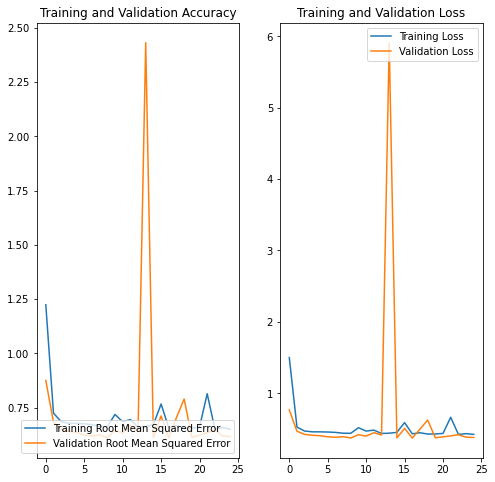

In [57]:
# code for plotting the results from the model for loss and root mean square error
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 2

In [60]:
model2 = Sequential()
model2.add(Dense(128, input_shape=(X_train_scaled.shape[1:]), kernel_initializer='uniform', activation=k.layers.LeakyReLU(alpha=0.01)))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(64, kernel_initializer='uniform', activation=k.layers.LeakyReLU(alpha=0.01)))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(32, kernel_initializer='uniform', activation=k.layers.LeakyReLU(alpha=0.01)))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(1, kernel_initializer='uniform',activation='linear'))
	# Compile model
  
opt = Adam() 
model2.compile(loss='mean_squared_error', optimizer=opt, metrics=[k.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [61]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               9344      
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)               

In [62]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)


callbacks_list = [checkpoint, early_stopping]

In [63]:

history = model2.fit(X_train_scaled,y_train_log, validation_data=(X_val_scaled, y_val_log), epochs=100, batch_size=64, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/100
28462/28491 [============================>.] - ETA: 0s - loss: 2.6849 - root_mean_squared_error: 1.6386 - r2_score: -1.3299
Epoch 00001: val_loss improved from inf to 0.71833, saving model to DMSP2_2022-10-3023_02_24.505680\model-00001-2.68287-1.63795-0.71833-0.84754.h5
28491/28491 [==============================] - 34s 1ms/step - loss: 2.6829 - root_mean_squared_error: 1.6379 - r2_score: -1.3281 - val_loss: 0.7183 - val_root_mean_squared_error: 0.8475 - val_r2_score: 0.3264
Epoch 2/100
28472/28491 [============================>.] - ETA: 0s - loss: 0.6870 - root_mean_squared_error: 0.8289 - r2_score: 0.4652
Epoch 00002: val_loss improved from 0.71833 to 0.45704, saving model to DMSP2_2022-10-3023_02_24.505680\model-00002-0.68698-0.82884-0.45704-0.67605.h5
28491/28491 [==============================] - 32s 1ms/step - loss: 0.6870 - root_mean_squared_error: 0.8288 - r2_score: 0.4652 - val_loss: 0.4570 - val_root_mean_squared_error: 0.6760 - val_r2_score: 0.5683
Epoch 3/100
28

Epoch 20/100
28446/28491 [============================>.] - ETA: 0s - loss: 0.6389 - root_mean_squared_error: 0.7993 - r2_score: 0.5005
Epoch 00020: val_loss improved from 0.38768 to 0.38650, saving model to DMSP2_2022-10-3023_02_24.505680\model-00020-0.63876-0.79923-0.38650-0.62169.h5
28491/28491 [==============================] - 31s 1ms/step - loss: 0.6388 - root_mean_squared_error: 0.7992 - r2_score: 0.5005 - val_loss: 0.3865 - val_root_mean_squared_error: 0.6217 - val_r2_score: 0.6324
Epoch 21/100
28454/28491 [============================>.] - ETA: 0s - loss: 0.6382 - root_mean_squared_error: 0.7989 - r2_score: 0.5013
Epoch 00021: val_loss did not improve from 0.38650
28491/28491 [==============================] - 31s 1ms/step - loss: 0.6382 - root_mean_squared_error: 0.7989 - r2_score: 0.5013 - val_loss: 0.3905 - val_root_mean_squared_error: 0.6249 - val_r2_score: 0.6298
Epoch 22/100
28452/28491 [============================>.] - ETA: 0s - loss: 0.6377 - root_mean_squared_error: 

Epoch 40/100
28485/28491 [============================>.] - ETA: 0s - loss: 0.6339 - root_mean_squared_error: 0.7962 - r2_score: 0.5041
Epoch 00040: val_loss did not improve from 0.38312
28491/28491 [==============================] - 31s 1ms/step - loss: 0.6339 - root_mean_squared_error: 0.7962 - r2_score: 0.5041 - val_loss: 0.3878 - val_root_mean_squared_error: 0.6227 - val_r2_score: 0.6322
Epoch 41/100
28459/28491 [============================>.] - ETA: 0s - loss: 0.6333 - root_mean_squared_error: 0.7958 - r2_score: 0.5047
Epoch 00041: val_loss improved from 0.38312 to 0.38228, saving model to DMSP2_2022-10-3023_02_24.505680\model-00041-0.63318-0.79573-0.38228-0.61829.h5
28491/28491 [==============================] - 31s 1ms/step - loss: 0.6332 - root_mean_squared_error: 0.7957 - r2_score: 0.5047 - val_loss: 0.3823 - val_root_mean_squared_error: 0.6183 - val_r2_score: 0.6366
Epoch 42/100
28488/28491 [============================>.] - ETA: 0s - loss: 0.6338 - root_mean_squared_error: 

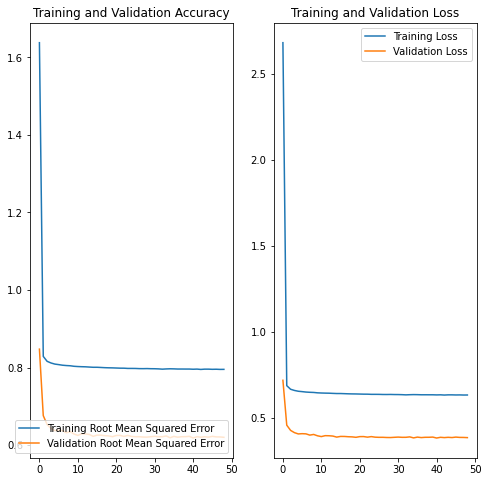

In [66]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(49)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 3

In [ ]:
model3 = Sequential()
model3.add(Dense(256, input_shape=(X_train_scaled.shape[1:]), kernel_initializer='normal', activation=k.layers.LeakyReLU(alpha=0.02)))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Dense(128, kernel_initializer='uniform', activation=k.layers.LeakyReLU(alpha=0.02)))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Dense(64, kernel_initializer='uniform', activation=k.layers.LeakyReLU(alpha=0.02)))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Dense(32, kernel_initializer='uniform', activation=k.layers.LeakyReLU(alpha=0.02)))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Dense(1, kernel_initializer='uniform',activation='linear'))
	# Compile model
  
opt = Adam(0.0001) 
model3.compile(loss='mean_squared_error', optimizer=opt, metrics=[k.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [ ]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 256)               18688     
                                                                 
 batch_normalization_7 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_8 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 128)              

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

# LR = # write the REducelronplateau code here
callbacks_list = [checkpoint, early_stopping]

In [ ]:

history = model3.fit(X_train_scaled,y_train_log, validation_data=(X_val_scaled, y_val_log), epochs=100, batch_size=100, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/100
1469/1470 [============================>.] - ETA: 0s - loss: 90.5435 - root_mean_squared_error: 9.5154 - r2_score: -86.5053
Epoch 1: val_loss improved from inf to 82.64878, saving model to DMSP3_2022-08-2016_41_31.154239/model-00001-90.54727-9.51563-82.64878-9.09114.h5
1470/1470 [==============================] - 9s 5ms/step - loss: 90.5473 - root_mean_squared_error: 9.5156 - r2_score: -86.4751 - val_loss: 82.6488 - val_root_mean_squared_error: 9.0911 - val_r2_score: -83.1232
Epoch 2/100
1466/1470 [============================>.] - ETA: 0s - loss: 59.7793 - root_mean_squared_error: 7.7317 - r2_score: -56.5343
Epoch 2: val_loss improved from 82.64878 to 37.80687, saving model to DMSP3_2022-08-2016_41_31.154239/model-00002-59.75034-7.72983-37.80687-6.14873.h5
1470/1470 [==============================] - 7s 5ms/step - loss: 59.7503 - root_mean_squared_error: 7.7298 - r2_score: -56.4683 - val_loss: 37.8069 - val_root_mean_squared_error: 6.1487 - val_r2_score: -37.4594
Epoch 3/1

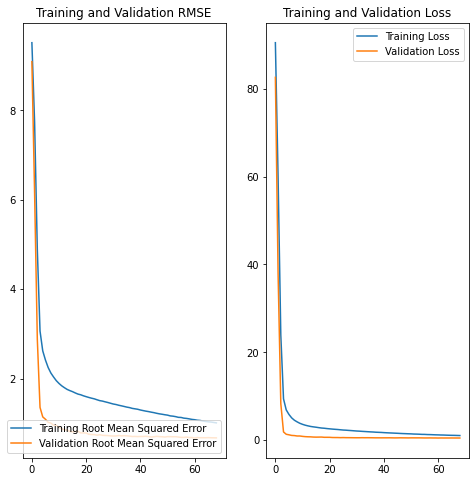

In [ ]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(69)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 4

In [ ]:
model4 = Sequential()
model4.add(Dense(512, input_shape=(X_train_scaled.shape[1:]), kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))
model4.add(BatchNormalization())
model4.add(Dropout(0.25))
model4.add(Dense(256, kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))
model4.add(BatchNormalization())
model4.add(Dropout(0.25))
model4.add(Dense(128, kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))
model4.add(BatchNormalization())
model4.add(Dropout(0.25))
model4.add(Dense(64, kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))
model4.add(BatchNormalization())
model4.add(Dropout(0.25))
model4.add(Dense(32, kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))
model4.add(Dense(1, kernel_initializer='normal',activation='linear'))
	# Compile model
  
opt = Adam(0.001)
model4.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [ ]:
model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 512)               37376     
                                                                 
 batch_normalization_11 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_12 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 256)              

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP4' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)


callbacks_list = [checkpoint, early_stopping]

In [ ]:
history = model4.fit(X_train_scaled,y_train_log, validation_data=(X_val_scaled, y_val_log), epochs=100, batch_size=64, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/100
2286/2296 [============================>.] - ETA: 0s - loss: 15.8247 - root_mean_squared_error: 3.9780 - r2_score: -13.5472
Epoch 1: val_loss improved from inf to 1.03372, saving model to DMSP4_2022-08-2016_51_37.627357/model-00001-15.77482-3.97175-1.03372-1.01672.h5
2296/2296 [==============================] - 15s 6ms/step - loss: 15.7748 - root_mean_squared_error: 3.9718 - r2_score: -13.5028 - val_loss: 1.0337 - val_root_mean_squared_error: 1.0167 - val_r2_score: 0.0246
Epoch 2/100
2289/2296 [============================>.] - ETA: 0s - loss: 3.2334 - root_mean_squared_error: 1.7982 - r2_score: -2.1567
Epoch 2: val_loss improved from 1.03372 to 0.95043, saving model to DMSP4_2022-08-2016_51_37.627357/model-00002-3.23537-1.79871-0.95043-0.97490.h5
2296/2296 [==============================] - 13s 6ms/step - loss: 3.2354 - root_mean_squared_error: 1.7987 - r2_score: -2.1565 - val_loss: 0.9504 - val_root_mean_squared_error: 0.9749 - val_r2_score: 0.0881
Epoch 3/100
2288/2296 [

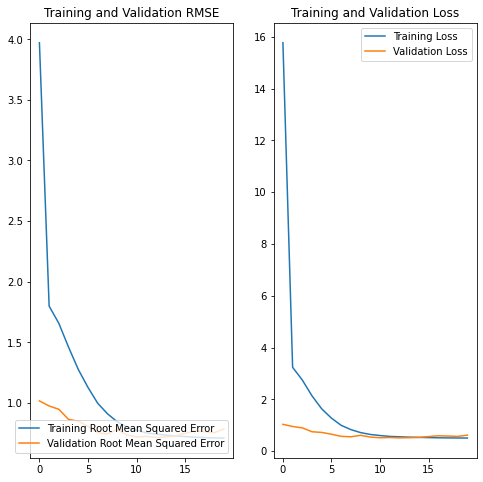

In [ ]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 5

In [ ]:
model5 = Sequential()
model5.add(Dense(512, input_shape=(X_train_scaled.shape[1:]), kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))

model5.add(Dropout(0.25))
model5.add(Dense(256, kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))

model5.add(Dropout(0.25))
model5.add(Dense(128, kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))

model5.add(Dropout(0.25))
model5.add(Dense(64, kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))

model5.add(Dropout(0.25))
model5.add(Dense(32, kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))

model5.add(Dropout(0.25))
model5.add(Dense(16, kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))

model5.add(Dropout(0.25))
model5.add(Dense(1, kernel_initializer='normal',activation='linear'))
	# Compile model
  
opt = Adam(0.002) 
model5.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [ ]:
model5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               37376     
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 64)               

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP5' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

callbacks_list = [checkpoint, LR, early_stopping]

In [ ]:
history = model5.fit(X_train_scaled,y_train_log, validation_data=(X_val_scaled, y_val_log), epochs=100, batch_size=64, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/100
2296/2296 [==============================] - ETA: 0s - loss: 16.4840 - root_mean_squared_error: 4.0600 - r2_score: -14.6888
Epoch 1: val_loss improved from inf to 10.85903, saving model to DMSP5_2022-08-2016_57_27.546700/model-00001-16.48396-4.06004-10.85903-3.29530.h5
2296/2296 [==============================] - 9s 4ms/step - loss: 16.4840 - root_mean_squared_error: 4.0600 - r2_score: -14.6888 - val_loss: 10.8590 - val_root_mean_squared_error: 3.2953 - val_r2_score: -10.2458 - lr: 0.0020
Epoch 2/100
2290/2296 [============================>.] - ETA: 0s - loss: 5.2800 - root_mean_squared_error: 2.2978 - r2_score: -4.0564
Epoch 2: val_loss improved from 10.85903 to 2.47637, saving model to DMSP5_2022-08-2016_57_27.546700/model-00002-5.28472-2.29885-2.47637-1.57365.h5
2296/2296 [==============================] - 8s 3ms/step - loss: 5.2847 - root_mean_squared_error: 2.2989 - r2_score: -4.0577 - val_loss: 2.4764 - val_root_mean_squared_error: 1.5736 - val_r2_score: -1.6210 - lr:

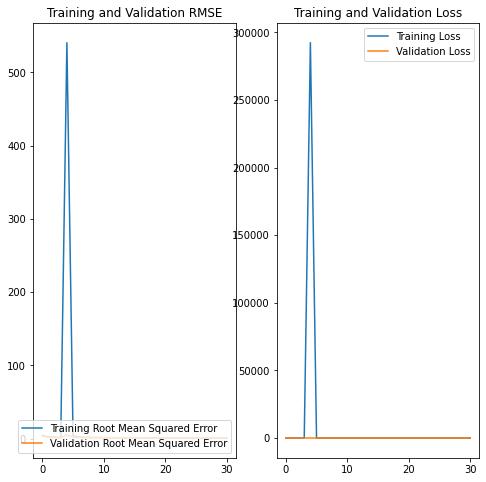

In [ ]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(31)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# as LSTM takes input in a particular format, we reshape the training and validation data
import numpy
train_X = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
#train_X = numpy.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
val_X = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))

In [ ]:
train_X

array([[[-1.30186897, -5.92397314, -0.34384096, ...,  0.09523256,
         -0.54847415,  0.60543444]],

       [[-1.03008105, -5.92397314, -0.34985504, ...,  0.09523256,
         -0.54847415,  0.60543444]],

       [[-0.23205524, -5.92397314, -0.36785615, ...,  0.15030447,
         -0.66353677,  0.53624339]],

       ...,

       [[-1.72867869, -1.27842581, -1.39796897, ..., -1.4467809 ,
         -0.53340643, -0.043897  ]],

       [[-0.83030017, -1.27842581, -1.40084246, ..., -2.42889662,
         -0.51559912,  0.06787316]],

       [[ 1.25085749, -1.27842581, -1.33277228, ..., -0.13423373,
         -0.4388907 ,  0.06255078]]])

## Model 6

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm.add(Dense(1, activation='linear'))

opt = Adam(0.001) 
model_lstm.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [ ]:
model_lstm.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                35072     
                                                                 
 dense_32 (Dense)            (None, 1)                 65        
                                                                 
Total params: 35,137
Trainable params: 35,137
Non-trainable params: 0
_________________________________________________________________


In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP6' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)


callbacks_list = [checkpoint, early_stopping]

In [ ]:
history = model_lstm.fit(train_X, y_train_log, validation_data=(val_X, y_val_log), epochs=100, batch_size=128, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/100
1135/1148 [============================>.] - ETA: 0s - loss: 17.0616 - root_mean_squared_error: 4.1306 - r2_score: -14.1080
Epoch 1: val_loss improved from inf to 2.30658, saving model to DMSP6_2022-08-2017_07_15.297667/model-00001-16.88764-4.10946-2.30658-1.51874.h5
1148/1148 [==============================] - 7s 4ms/step - loss: 16.8876 - root_mean_squared_error: 4.1095 - r2_score: -13.9567 - val_loss: 2.3066 - val_root_mean_squared_error: 1.5187 - val_r2_score: -1.3032
Epoch 2/100
1140/1148 [============================>.] - ETA: 0s - loss: 1.4662 - root_mean_squared_error: 1.2109 - r2_score: -0.3033
Epoch 2: val_loss improved from 2.30658 to 1.37970, saving model to DMSP6_2022-08-2017_07_15.297667/model-00002-1.46546-1.21056-1.37970-1.17461.h5
1148/1148 [==============================] - 4s 4ms/step - loss: 1.4655 - root_mean_squared_error: 1.2106 - r2_score: -0.3039 - val_loss: 1.3797 - val_root_mean_squared_error: 1.1746 - val_r2_score: -0.3435
Epoch 3/100
1136/1148 [

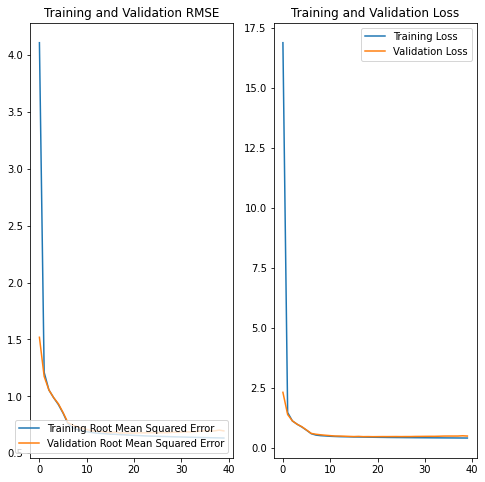

In [ ]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 7

In [ ]:
model_lstm2 = Sequential()
model_lstm2.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm2.add(Dropout(0.5))
model_lstm2.add(Dense(64, activation=keras.layers.LeakyReLU(alpha=0.02)))
model_lstm2.add(Dropout(0.5))
model_lstm2.add(Dense(1, activation='linear'))
opt = Adam(0.001) 
model_lstm2.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [ ]:
model_lstm2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               336896    
                                                                 
 dropout_22 (Dropout)        (None, 256)               0         
                                                                 
 dense_33 (Dense)            (None, 64)                16448     
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 1)                 65        
                                                                 
Total params: 353,409
Trainable params: 353,409
Non-trainable params: 0
_________________________________________________________________


In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP7' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

callbacks_list = [checkpoint, early_stopping]

In [ ]:
history = model_lstm2.fit(train_X, y_train_log, validation_data=(val_X, y_val_log), epochs=100, batch_size=128, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/100
1144/1148 [============================>.] - ETA: 0s - loss: 11.0697 - root_mean_squared_error: 3.3271 - r2_score: -8.9477
Epoch 1: val_loss improved from inf to 5.82694, saving model to DMSP7_2022-08-2017_11_08.489606/model-00001-11.07105-3.32732-5.82694-2.41390.h5
1148/1148 [==============================] - 8s 5ms/step - loss: 11.0710 - root_mean_squared_error: 3.3273 - r2_score: -8.9522 - val_loss: 5.8269 - val_root_mean_squared_error: 2.4139 - val_r2_score: -4.9999
Epoch 2/100
1140/1148 [============================>.] - ETA: 0s - loss: 4.5572 - root_mean_squared_error: 2.1347 - r2_score: -3.1880
Epoch 2: val_loss improved from 5.82694 to 1.18854, saving model to DMSP7_2022-08-2017_11_08.489606/model-00002-4.55238-2.13363-1.18854-1.09020.h5
1148/1148 [==============================] - 5s 4ms/step - loss: 4.5524 - root_mean_squared_error: 2.1336 - r2_score: -3.1920 - val_loss: 1.1885 - val_root_mean_squared_error: 1.0902 - val_r2_score: -0.1497
Epoch 3/100
1139/1148 [==

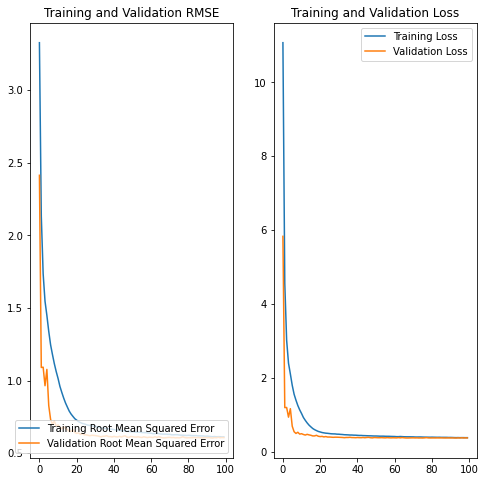

In [ ]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model_lstm3 = Sequential()
model_lstm3.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(Dense(128, activation=keras.layers.LeakyReLU(alpha=0.03)))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(Dense(64, activation=keras.layers.LeakyReLU(alpha=0.03)))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(Dense(32, activation=keras.layers.LeakyReLU(alpha=0.03)))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(Dense(16, activation=keras.layers.LeakyReLU(alpha=0.03)))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(Dense(8, activation=keras.layers.LeakyReLU(alpha=0.03)))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(Dense(1, activation='linear'))
opt = Adam(0.001)
model_lstm3.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [ ]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP8' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)


callbacks_list = [checkpoint, early_stopping]

In [ ]:
history = model_lstm3.fit(train_X, y_train_log, validation_data=(val_X, y_val_log), epochs=100, batch_size=128, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/100
1137/1148 [============================>.] - ETA: 0s - loss: 13.7886 - root_mean_squared_error: 3.7133 - r2_score: -11.5435
Epoch 1: val_loss improved from inf to 1.12801, saving model to DMSP8_2022-08-2017_20_46.520036/model-00001-13.72551-3.70480-1.12801-1.06208.h5
1148/1148 [==============================] - 8s 5ms/step - loss: 13.7255 - root_mean_squared_error: 3.7048 - r2_score: -11.5091 - val_loss: 1.1280 - val_root_mean_squared_error: 1.0621 - val_r2_score: -0.0863
Epoch 2/100
1145/1148 [============================>.] - ETA: 0s - loss: 6.0457 - root_mean_squared_error: 2.4588 - r2_score: -4.6998
Epoch 2: val_loss improved from 1.12801 to 1.10597, saving model to DMSP8_2022-08-2017_20_46.520036/model-00002-6.04733-2.45913-1.10597-1.05165.h5
1148/1148 [==============================] - 5s 5ms/step - loss: 6.0473 - root_mean_squared_error: 2.4591 - r2_score: -4.6984 - val_loss: 1.1060 - val_root_mean_squared_error: 1.0517 - val_r2_score: -0.0598
Epoch 3/100
1148/1148 [

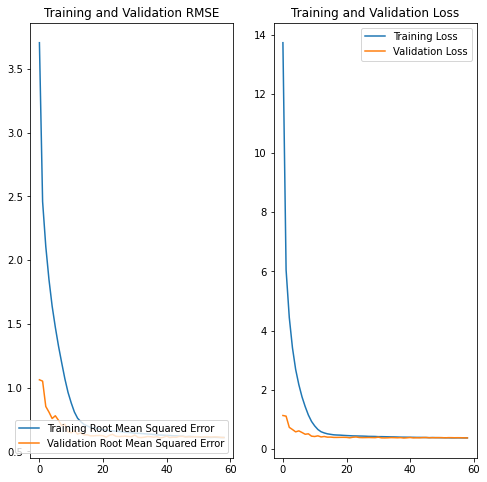

In [ ]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(59)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Results:

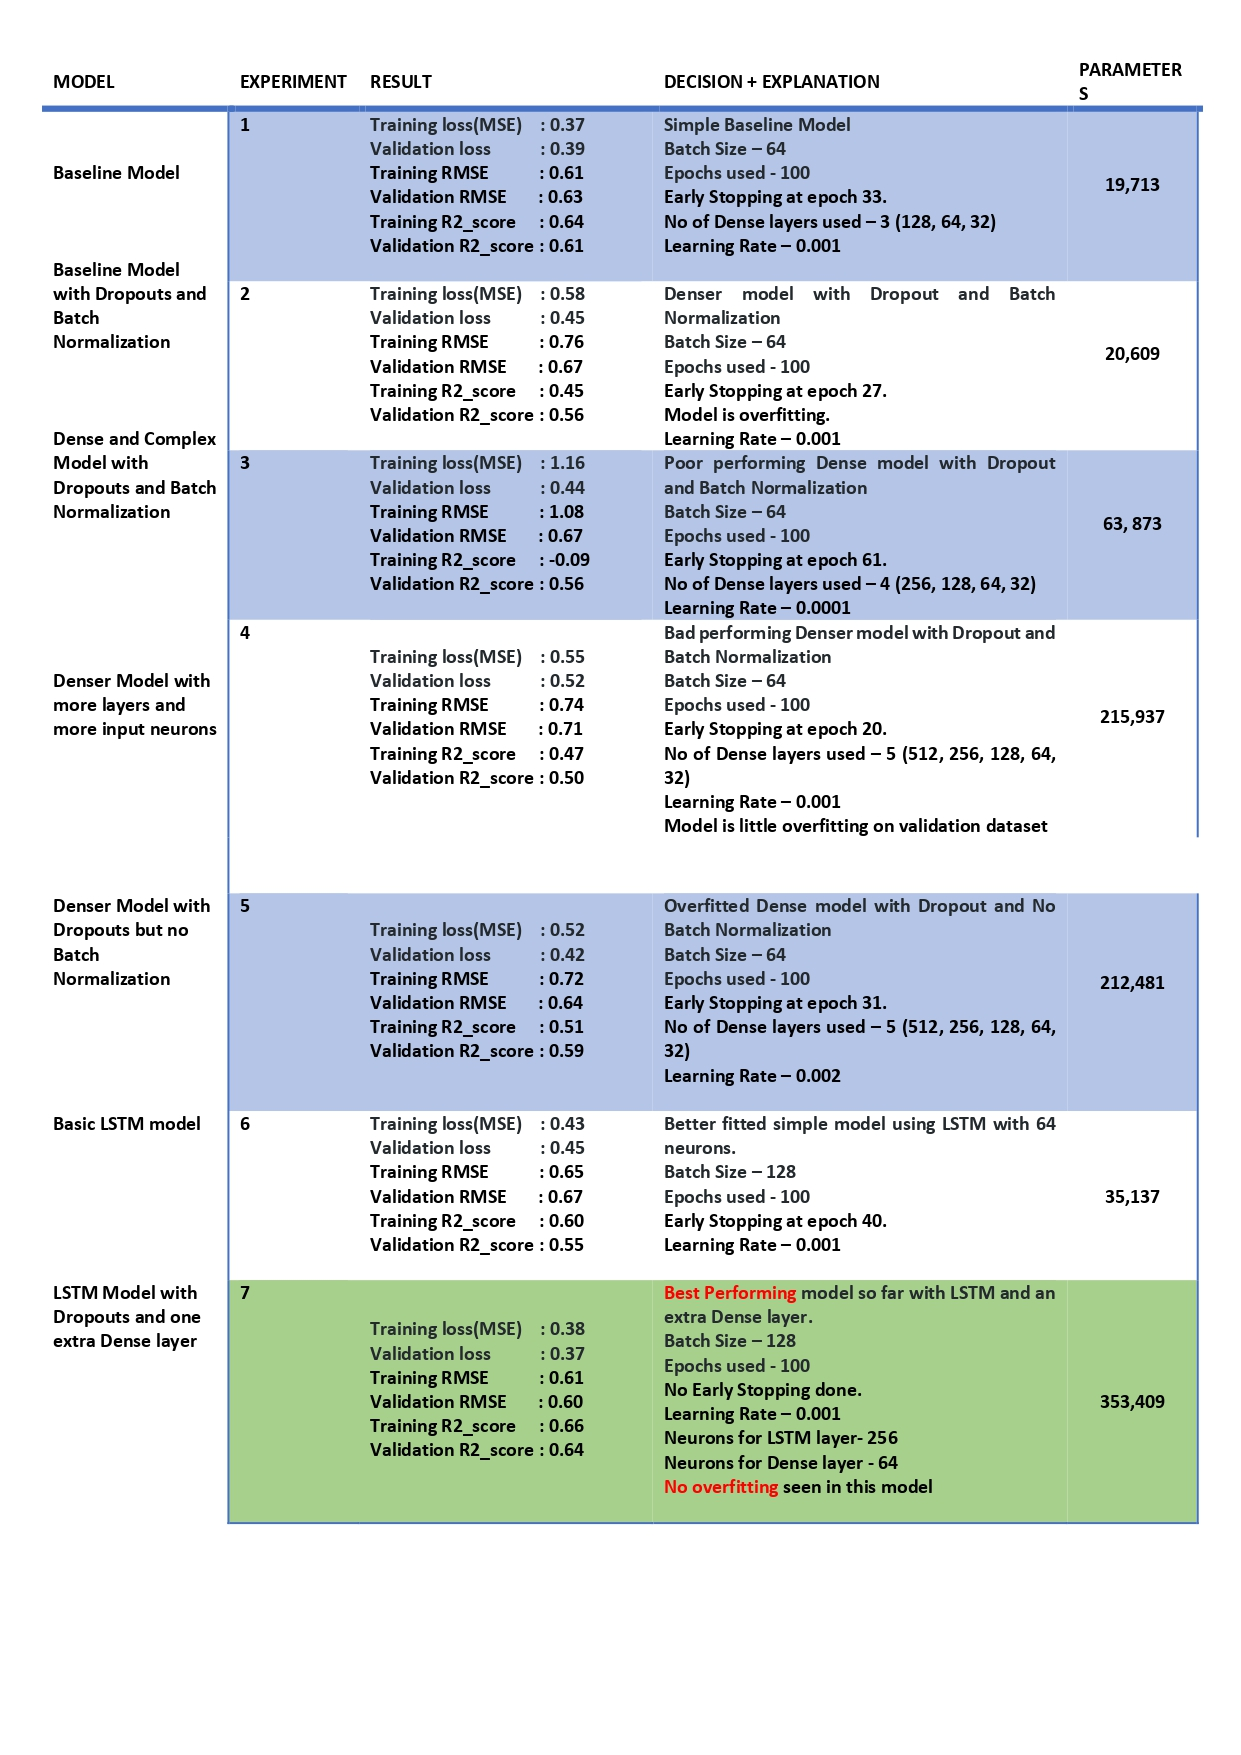